<a href="https://colab.research.google.com/github/MJMortensonWarwick/CLR_workshop/blob/main/CLR_with_BERTopic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Computational Literature Review with BERTopic
This notebook walks through implementing a CLR with BERTopic. If you want to follow along exactly with the initial build you can find the original dataset used [here](https://files.warwick.ac.uk/mmortenson/files/scopus.csv) (requires a University of Warwick IT account). Alternatively any Scopus file can be used but ensure you download as CSV and check to include the "Abstract".

We will being by installing an importing the necessary packages (libraries). _WARNING: this may take a few minutes._

In [1]:
%%capture
!pip install bertopic
!pip install wordcloud

In [2]:
import bertopic
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

Next we will import our Scopus file. The following code opens up a file picker for us to select our downloaded file. Click on "Select File" and follow the steps as usual for your device.

In [ ]:
from google.colab import files
files.upload()

Our file has now uploaded to the Colab instance. We can see it if we follow the following steps:
1. Click on the folder icon on the left-hand bar of the window;
2. From here, you will see two folder icons. The first has an up arrow and ".." as text and the second has "sample_data" written against it.
3. Click on the second icon above that has a folder with a refresh cycle in the corner. This will refresh the folder and you will see a new file titled "scopus.csv" (or whatever your file was titled.

We now want to import the data into a Pandas dataframe (Python):



In [ ]:
scopus = pd.read_csv("/content/scopus.csv") # imports the data
scopus.head() # prints the first 5 rows of the dataframe

We have imported the data and displayed the first 5 rows (this is what the __head()__ function does - alterantively you can pass a number between the brackets to display a custom number of rows).

With our data in Python we can create some basic visualisations.

##Exploratory Visualisation of the Data
We will create a save some charts to summarise our data. We will start by looking at publications per year:

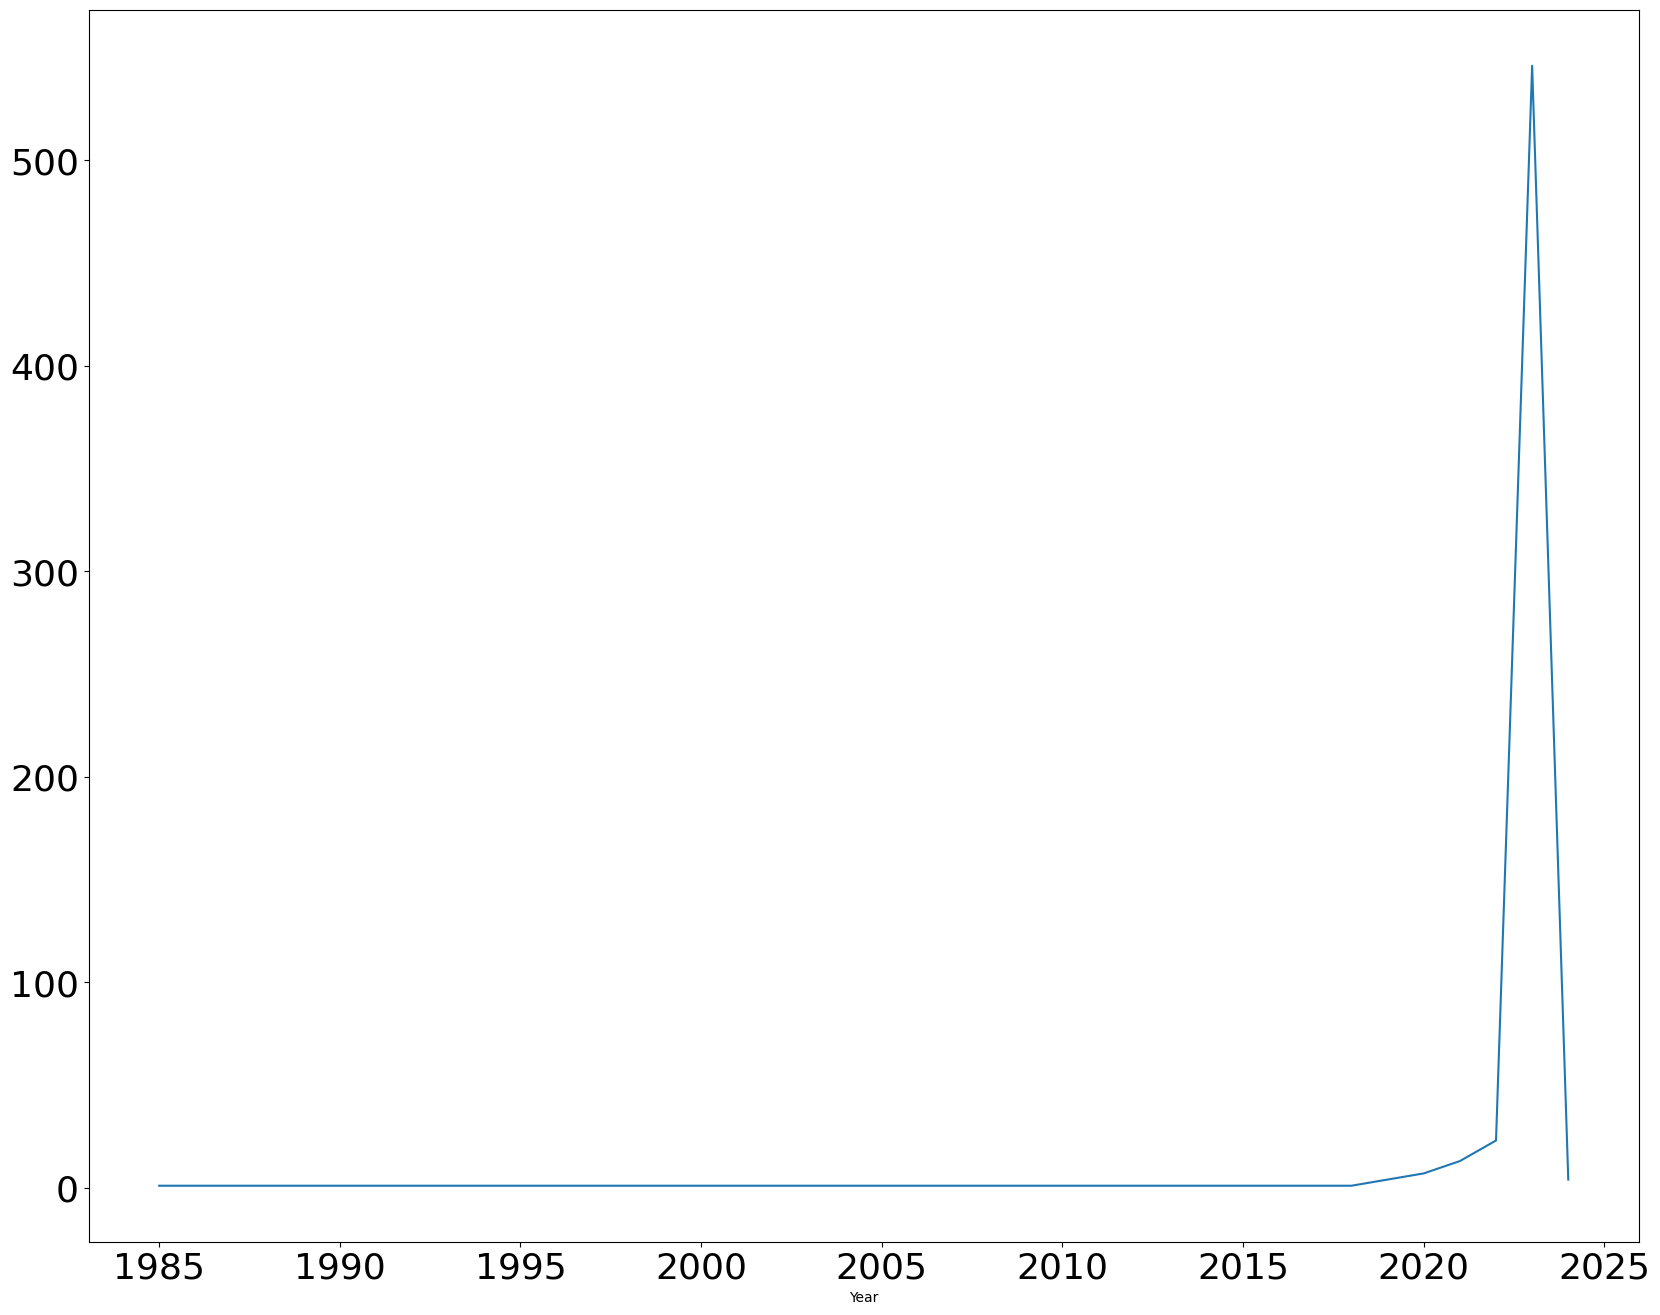

In [5]:
# group the data around years so we have one row per year with the count of entries per year
fig = scopus.groupby(scopus['Year']).size().plot(figsize=(20, 16), fontsize=26).get_figure()

fig.savefig('articlesByYear.pdf') # save and print the figure

If you are using the data for the tutorial, you will see a chart where there are very publications up until 2022, and then suddenly lots of publications. This makes sense given the search keywords. This chart can give a good indication if the search is growing in popularity, fairly stable or dropping in popularity.

_Note: you will also see a drop in the final year in nearly all searches. This is just because typically you are looking at incomplete data for the last years in the dataset. If you are familiar with Python you could change the code to cut off future years (and the current year)_

We also save the chart to the instance. If you go back to the left hand bar and click "refresh" again (the folder icon with the refresh cycle") a file titled "articlesByYear.pdf" will appear. You can download this by hovering over the name first of all, which will make three dots appear to the right of the title. Click on the three dots and you will see an option to "Download".

We will carry on with some more charts.

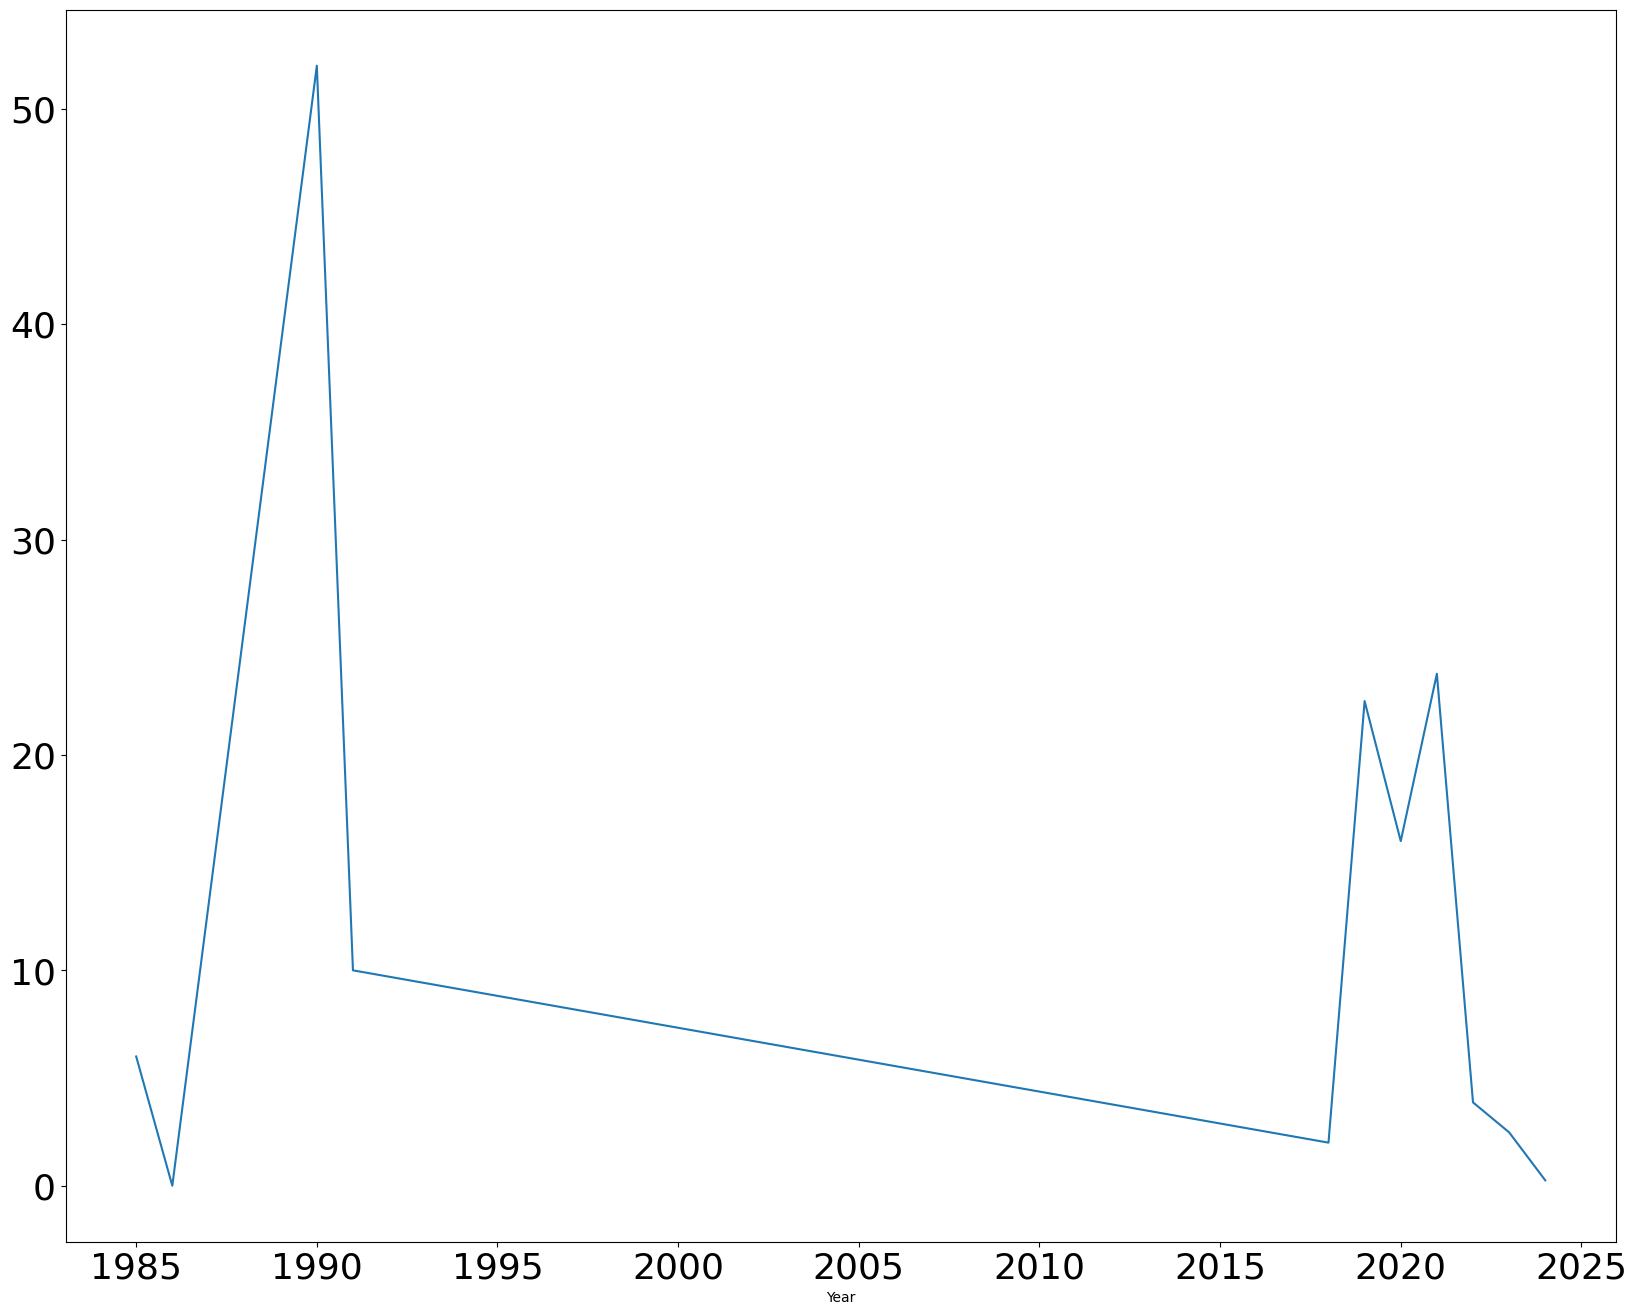

In [6]:
# Again we group by year but this time we are taking the mean average of citations ("Cited by")
fig = scopus["Cited by"].groupby(scopus['Year']).mean().plot(figsize=(20, 16), fontsize=26).get_figure()

fig.savefig('averageCitationsByYear.pdf')

The chart here works in the same fashion as the previous (and again has been saved to our instance to be downloaded). You can see our data skews a bit to older papers. This will be fairly common and is influenced by the fact that older papers have had more opportunity to acquire citations than newer publications. You can adjust this metric in various ways if you wish (e.g. converting to average citations per year since publication), but ultimately there is no "right answer" here.

Having evaluated the overall numbers of publications and citations, we will next look at individual papers, authors and sources (e.g. journals):

In [ ]:
scopus_sorted = scopus.sort_values(by=['Cited by'], ascending=False) # sort by "Cited by"
scopus_sorted = scopus_sorted[:20] # extract just the top 20 rows
scopus_sorted.head()

In the above example we have sorted all papers into order of citation (highest citations first). We have then created a new dataframe that stores just the top 20 papers (by citation) ready to visualise:

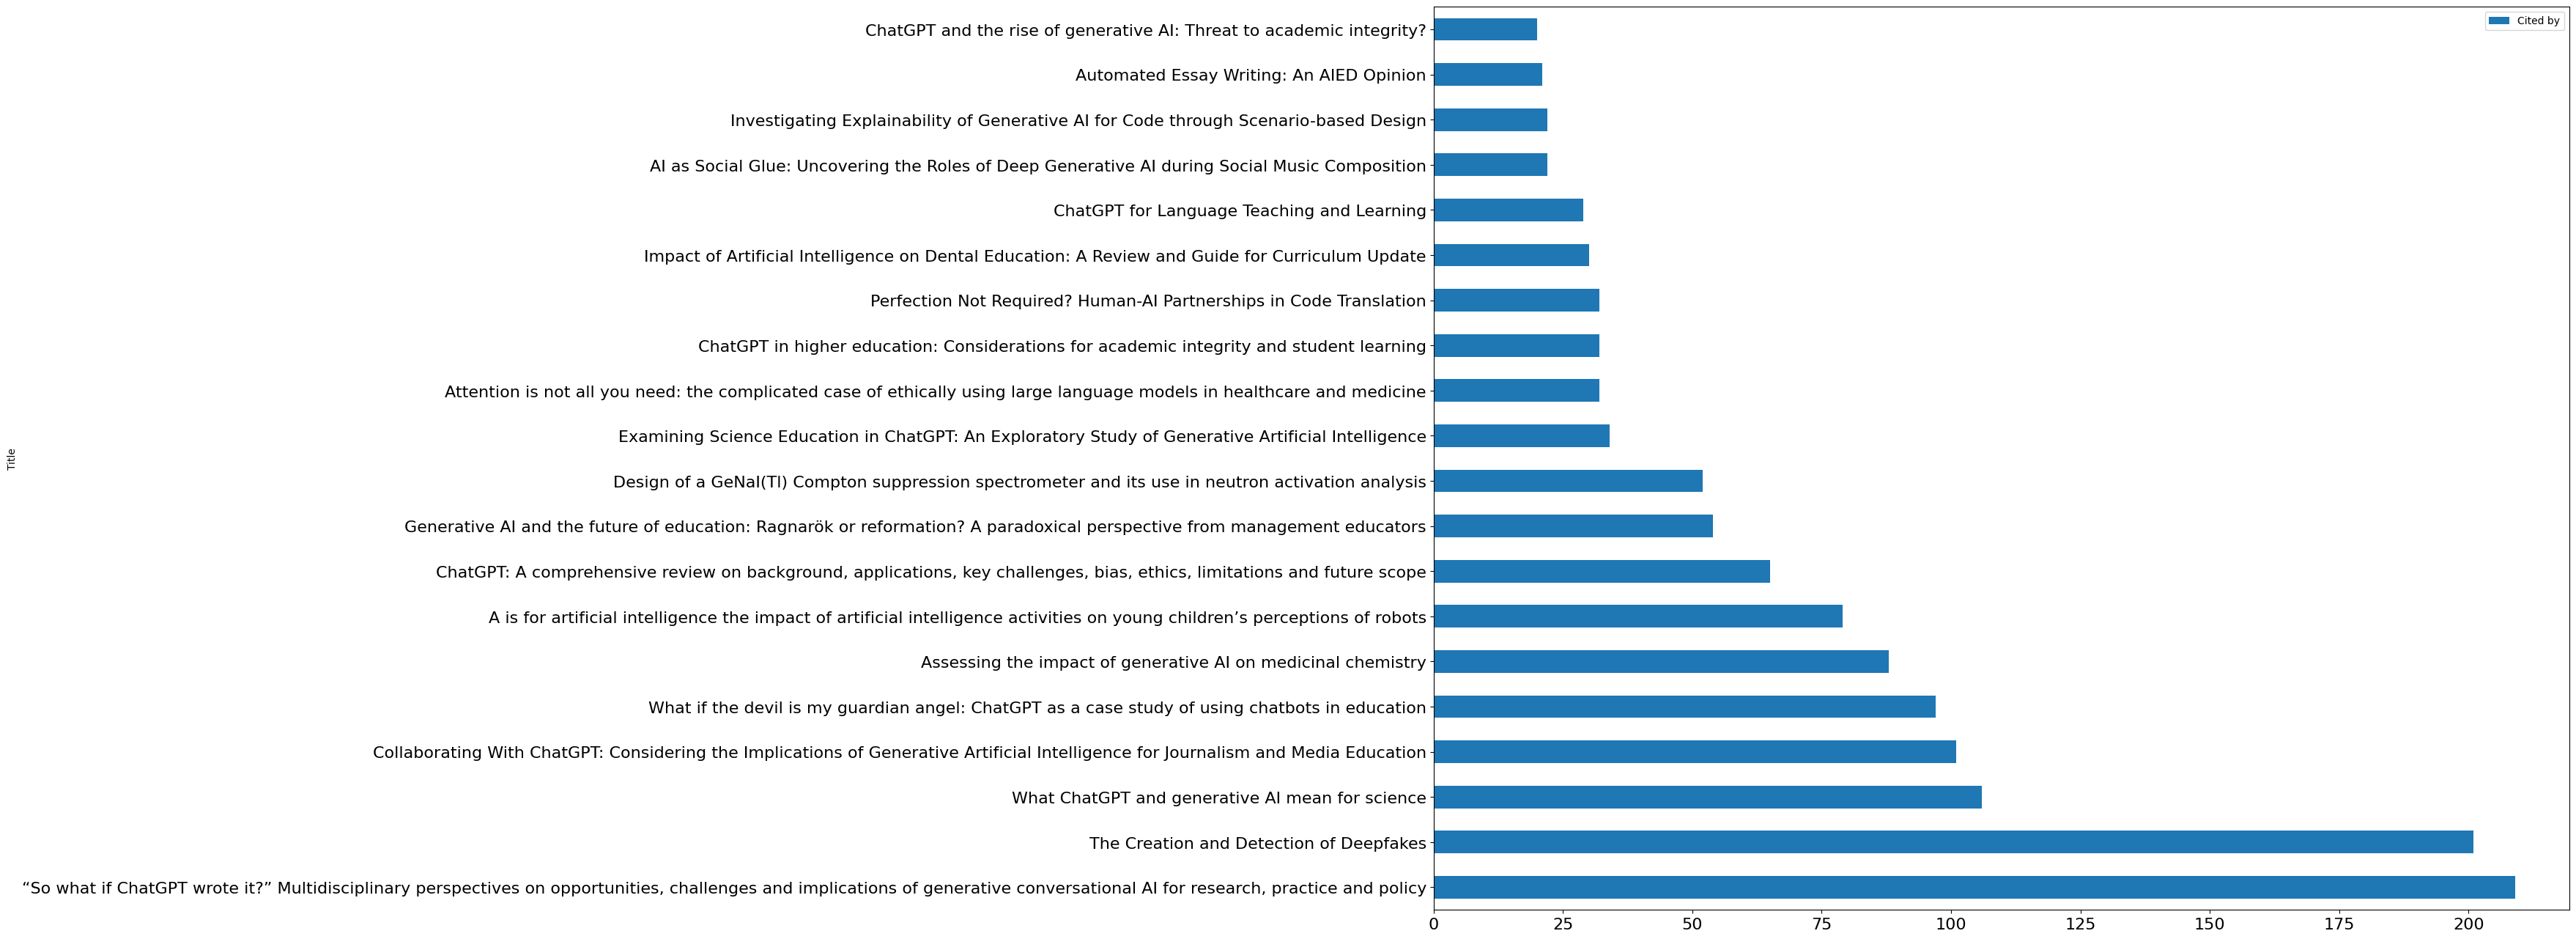

In [8]:
# plot the top 20 as a horizontal bar chart
fig = scopus_sorted.plot(figsize=(20, 16), fontsize=16, kind='barh', x="Title", y="Cited by").get_figure()

fig.savefig('top20PapersByCitations.pdf', bbox_inches='tight')

Here we have the top 20 papers by citation both on screen and saved to the instance. Follow the steps above (refresh, three dots, download) if you want to save this to your local machine.

We will next do something similar for authors. However, for most papers there are multiple authors, so we'll need to do a bit of messing around to change the granularity of the data from one row per paper to one row per author ("exploding" the dataset).

In [9]:
scopus_authors = scopus[['Authors', "Cited by"]] # create a dataframe with just authors and citations

# change the "Authors" field into a list of each author (they are separated in the data with a semi-colon)
scopus_authors = scopus_authors.assign(**{'Authors':scopus_authors['Authors'].str.split(';')})

# explode the data to one row per author per paper
scopus_authors = scopus_authors.explode('Authors')

# sum up the number of citations per author
scopus_authors_summed = scopus_authors.groupby(['Authors']).sum().reset_index()

scopus_authors_summed.head()

,Authors,Cited by
0,Abdullah R.,0
1,Abioye T.,0
2,Abukhodair N.,6
3,Ackermann J.,1
4,Adam A.,10


Now we have a dataset which is the sum of citations per individual author. Note this is not perfect ... if an author's name varies in how it is listed across publications they can will be considered seperate entities. E.g. "M. Mortenson", "M.J. Mortenson" and "Mortenson MJ" will be considered as three separate authors. Not much you can do about this other than closely checking the data and where appropriate manually changing the name.

From this dataset we can visualise the results:

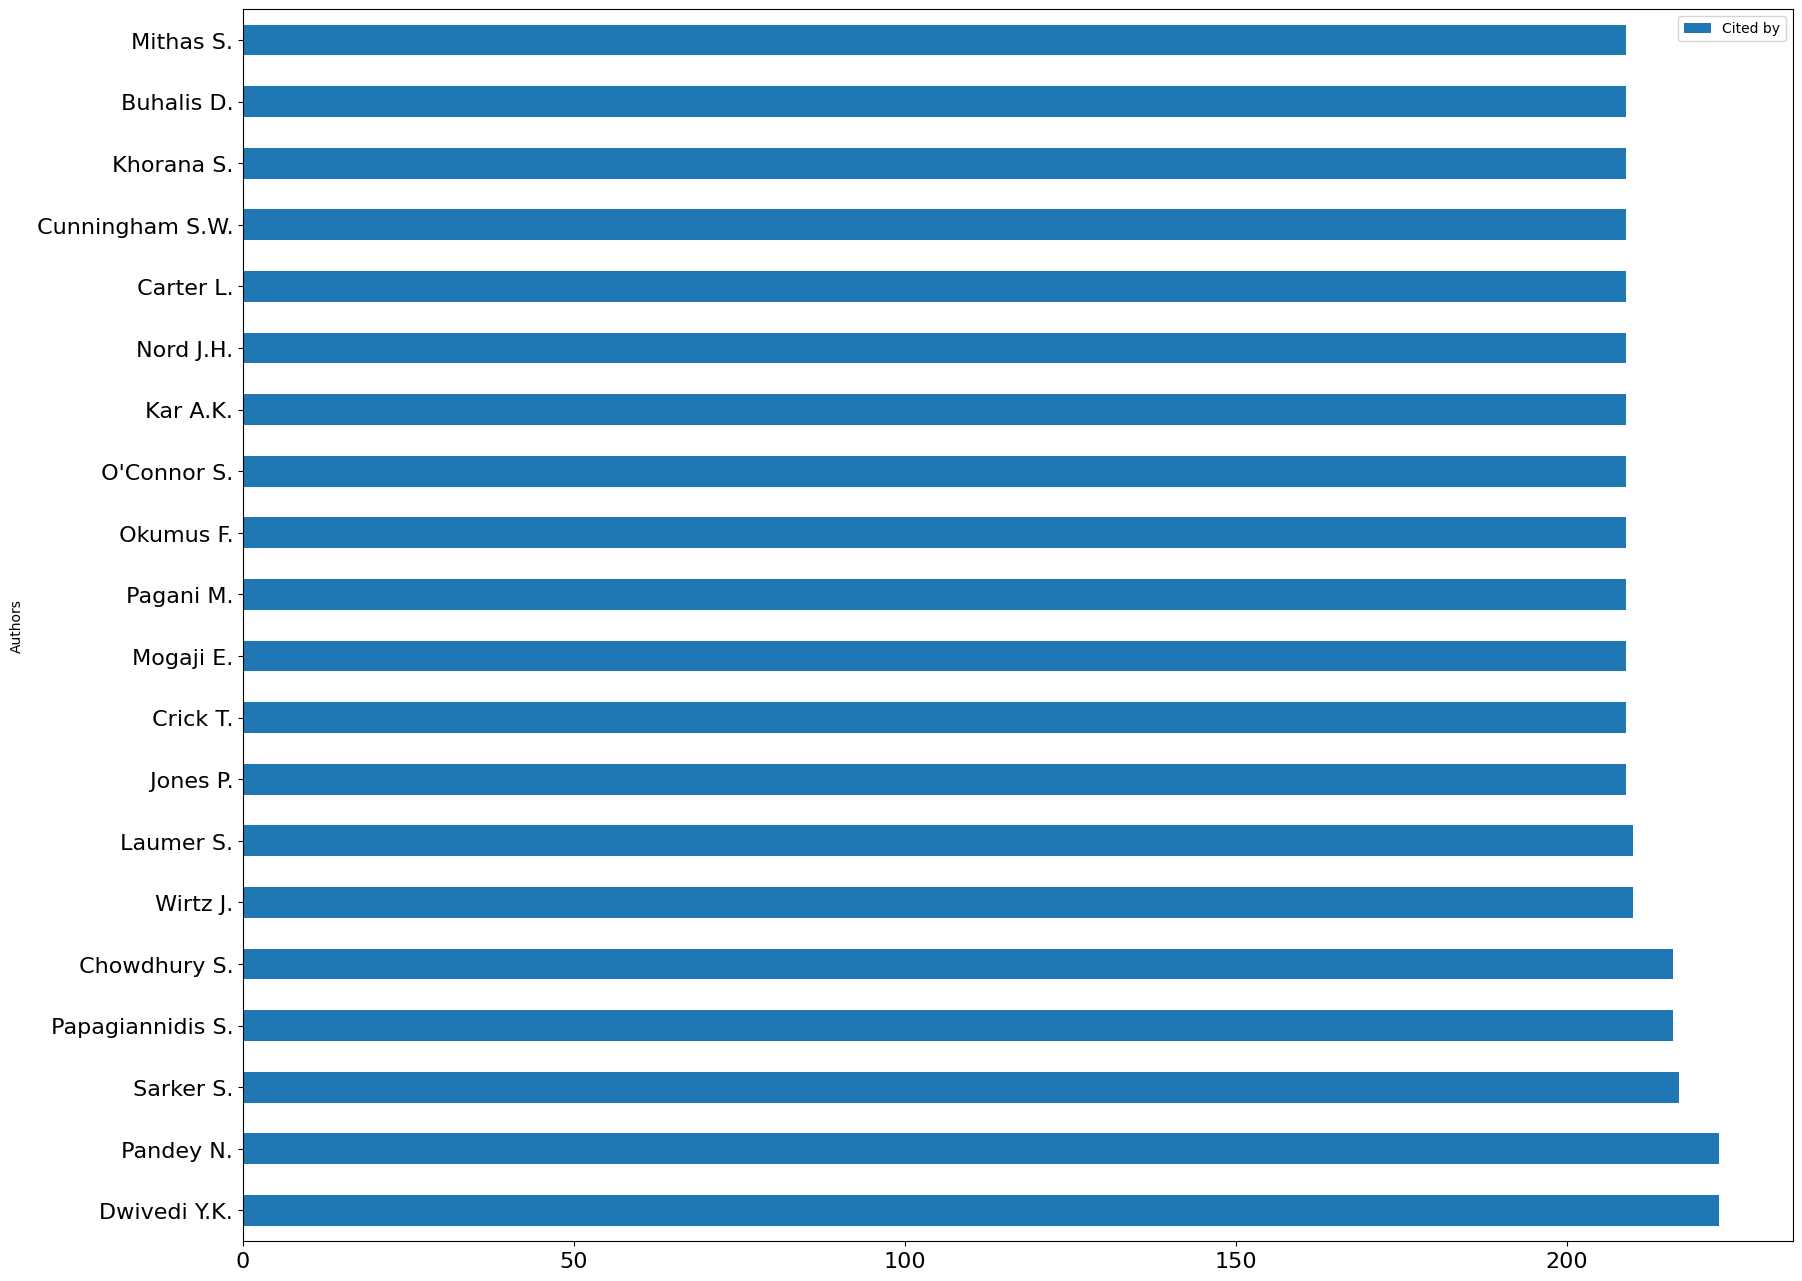

In [10]:
# as above, sort the data by citations, select the top 20 and print/save the figure
scopus_authors_summed = scopus_authors_summed.sort_values(by=['Cited by'], ascending=False).head(20).reset_index()

fig = scopus_authors_summed.plot(figsize=(20, 16), fontsize=16, kind='barh', x="Authors", y="Cited by").get_figure()

fig.savefig('top20AuthorsByCitations.pdf', bbox_inches='tight')

However, citation count alone can be a problematic metric, not just because it can favour older publications. It also can be effected by outliers (e.g. "one hit wonders"). Typically we prefer using [h-index](https://en.wikipedia.org/wiki/H-index) as a more complete metric in these settings.

_Note: the h-index we will calculate should be considered a "local" metric not a "global" metric. I.e. we will calculate the h-index for each author based only on the papers included in this database search not all their papers._

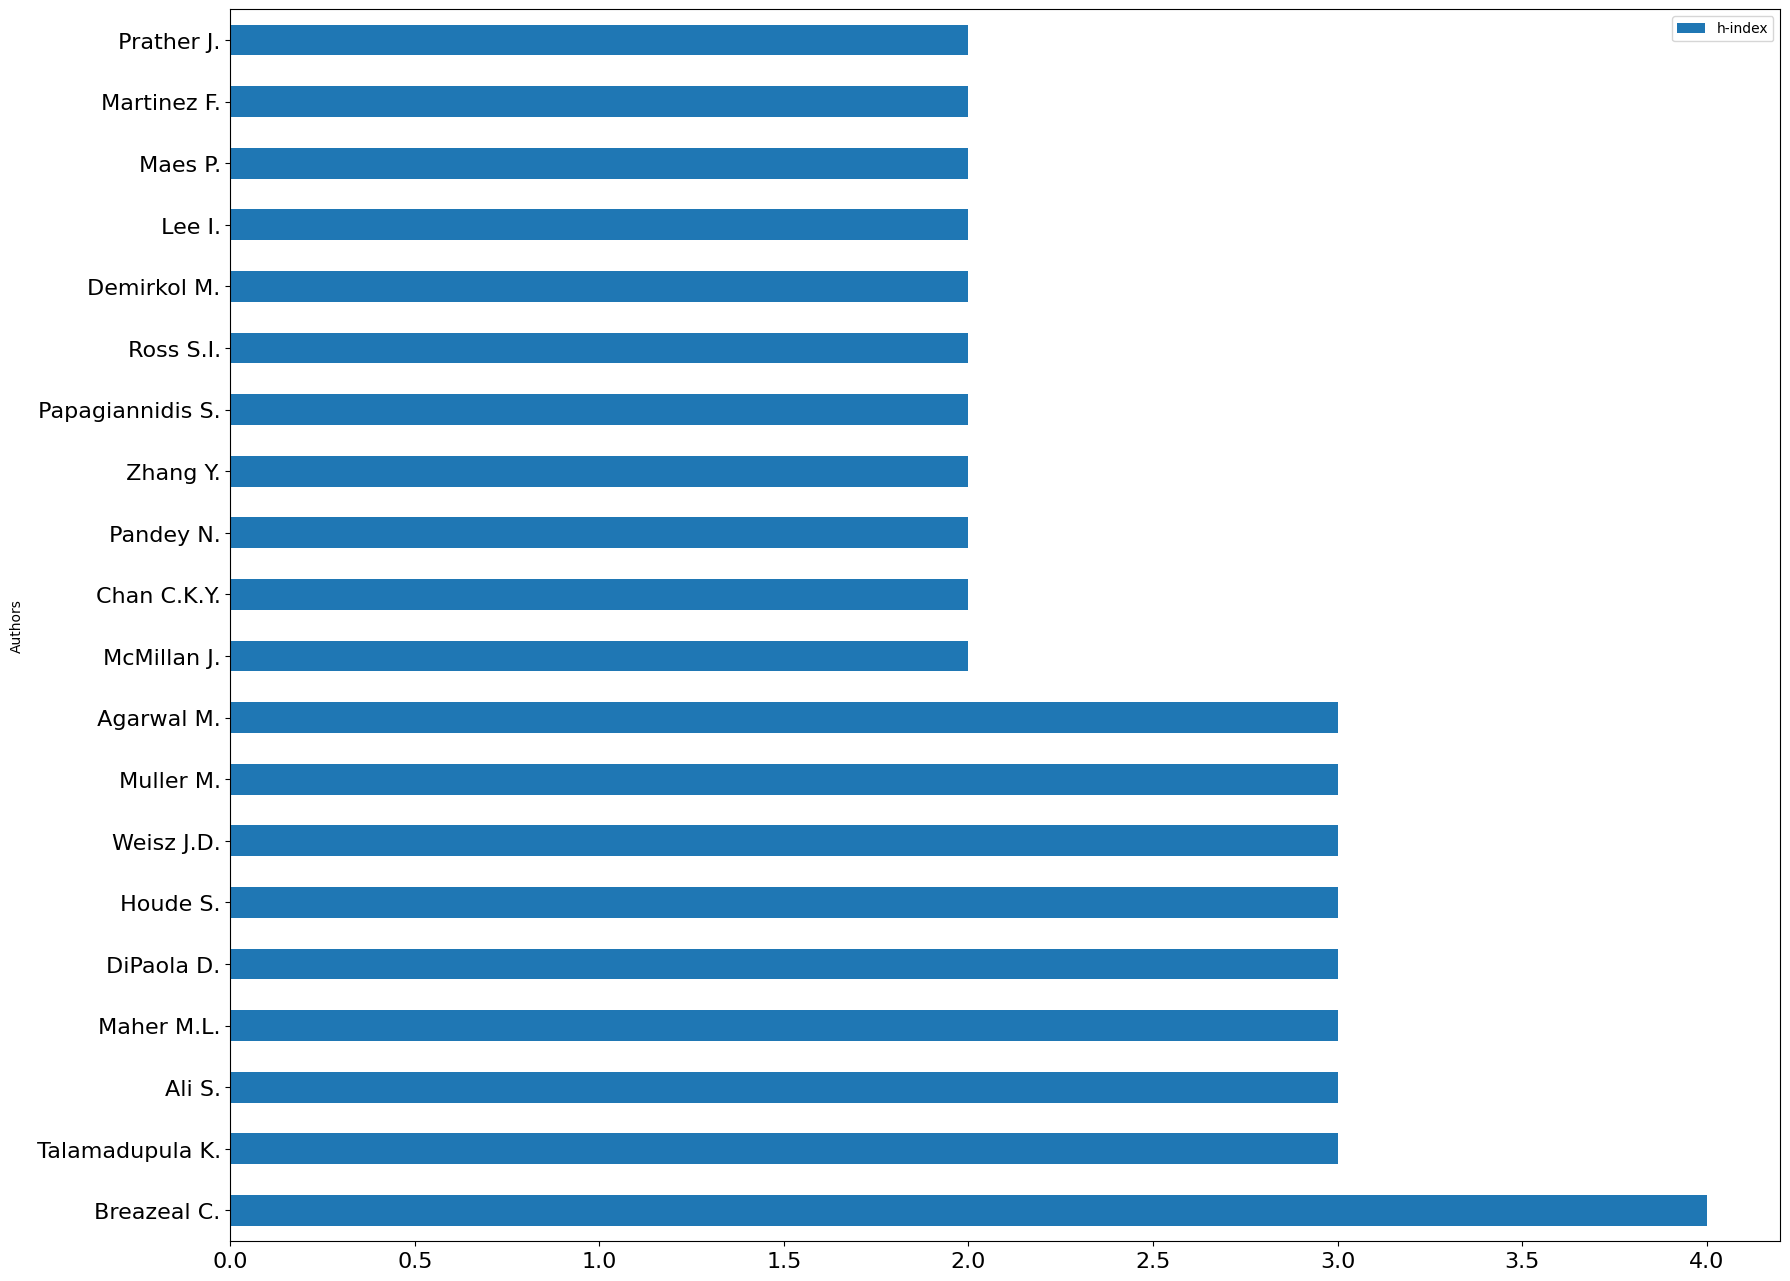

In [11]:
# calculate h-index from the "exploded" (one row per author) dataframe
scopus_authors['h-index'] = scopus_authors.groupby('Authors')['Cited by'].transform( lambda x: (x >= x.count()).sum() )

# reduce the dataframe to one row per author
scopus_authors = scopus_authors.groupby(['Authors']).max().reset_index()

# save this to a CSV in the instance
scopus_authors.to_csv("authors.csv", index=False)

# sort and find the top 20 and print/save the figure
scopus_authors_sorted = scopus_authors.sort_values(by=['h-index'], ascending=False).head(20).reset_index()

fig = scopus_authors_sorted.plot(figsize=(20, 16), fontsize=16, kind='barh', x="Authors", y="h-index").get_figure()

fig.savefig('top20AuthorsByHindex.pdf', bbox_inches='tight')

We can do the same thing for sources (e.g. the specific journal/conference/etc.) each paper is published in. As before, we will generate a visualisation for raw citations, followed by a new dataset and visualisation based on ("local") h-index:

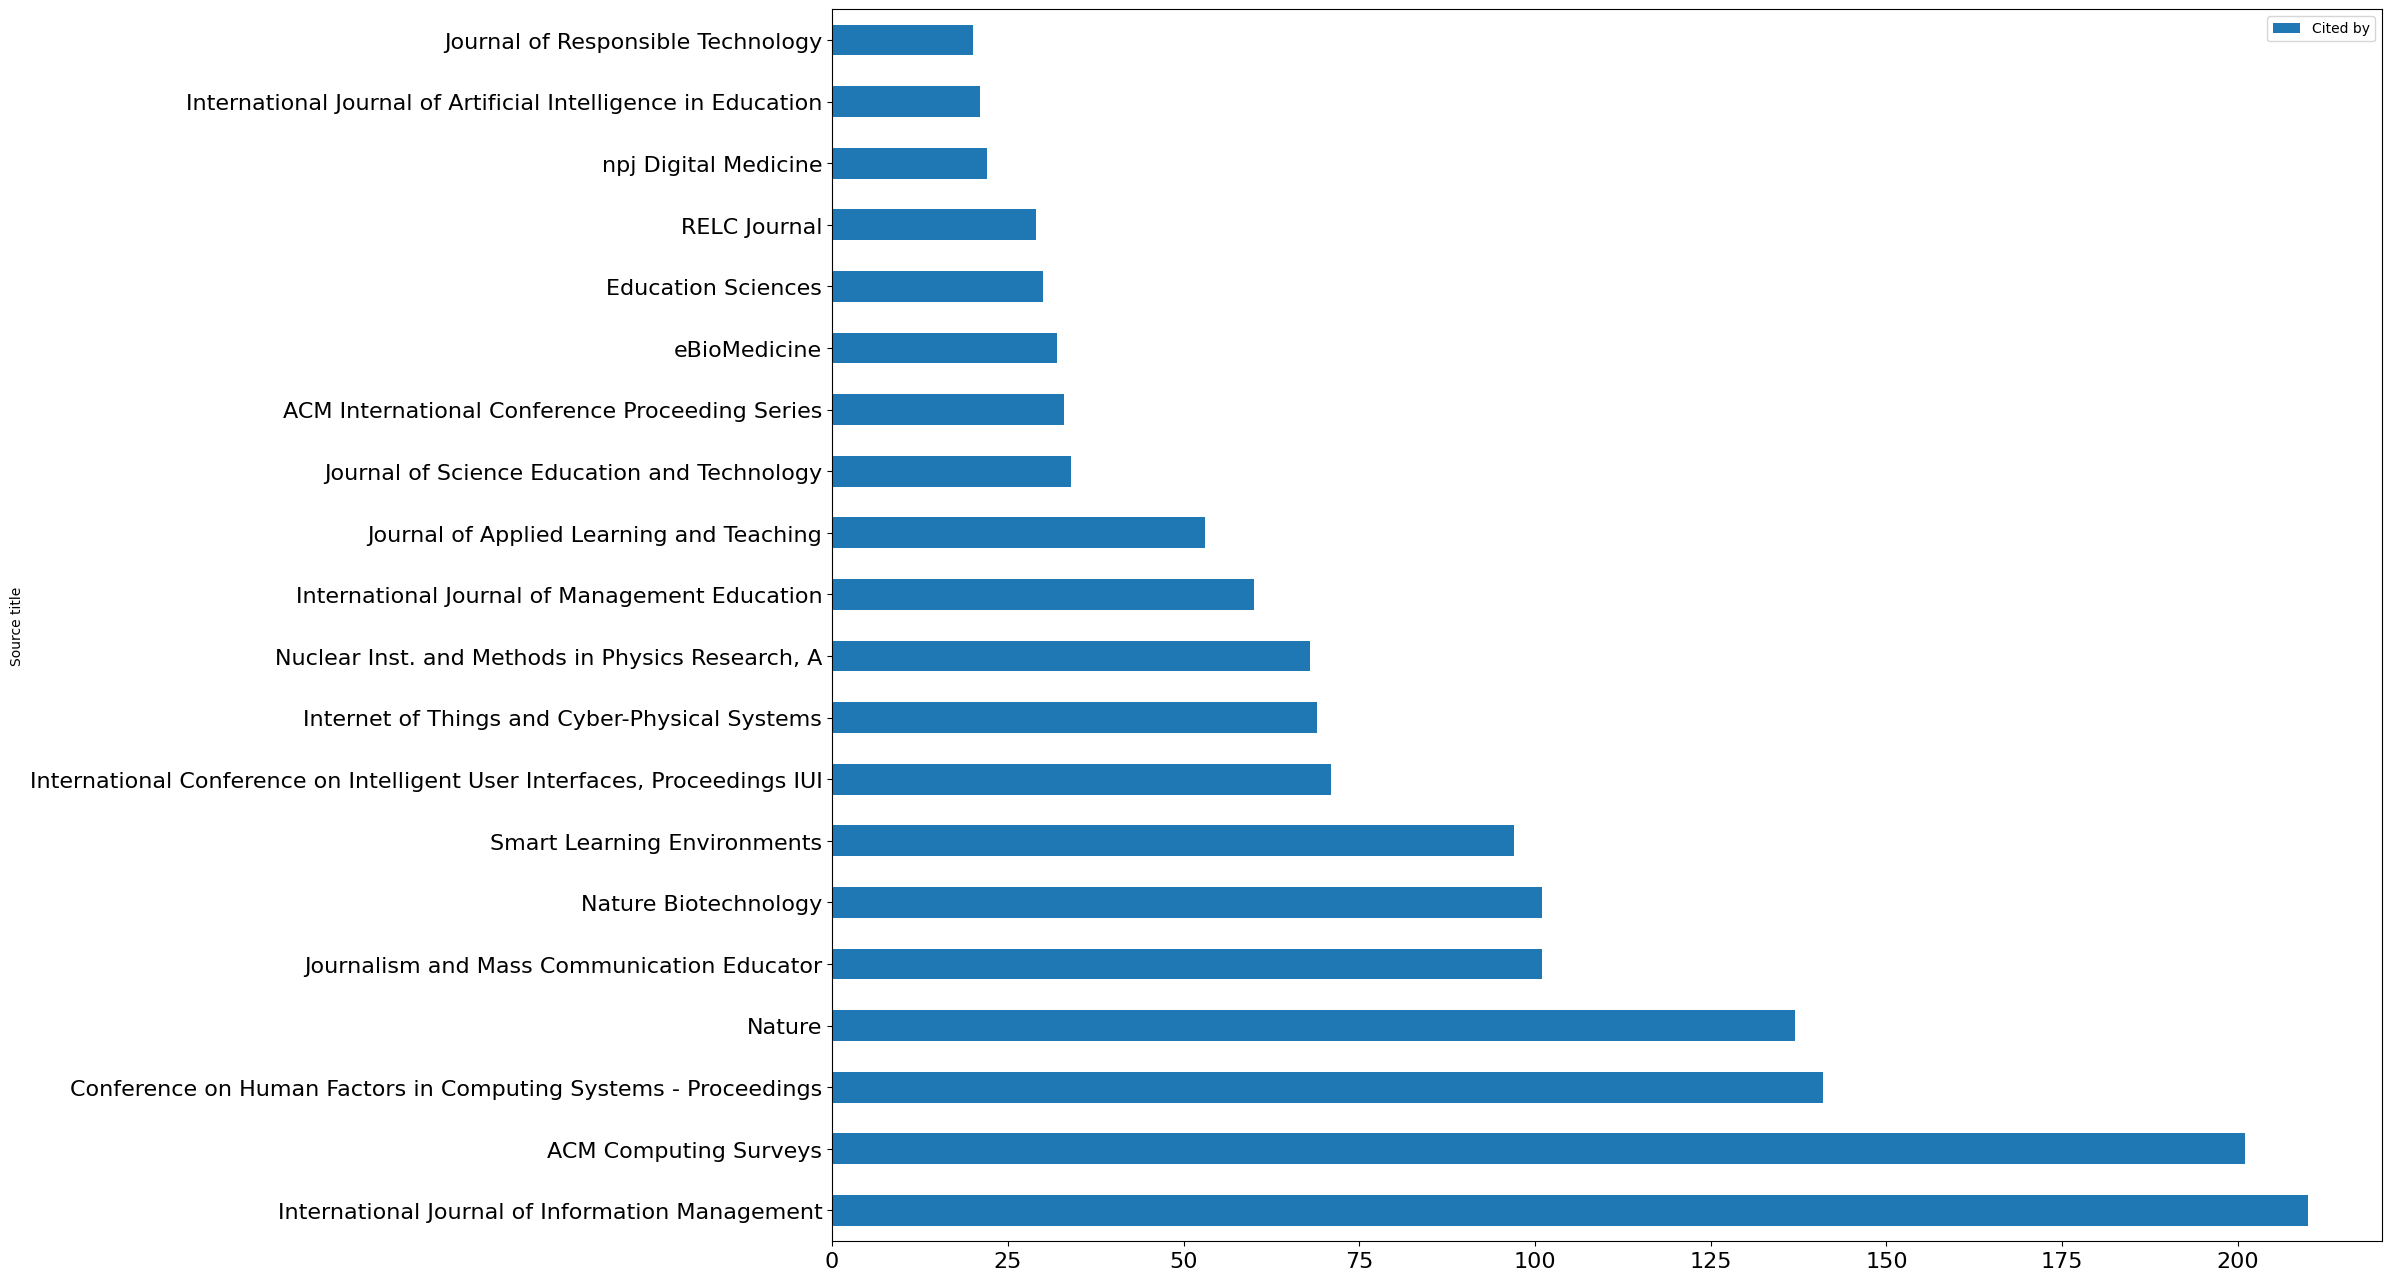

In [12]:
scopus_journals = scopus[['Source title', "Cited by"]]

scopus_journals_summed = scopus_journals.groupby(['Source title']).sum().reset_index()

scopus_journals_summed = scopus_journals_summed.sort_values(by=['Cited by'], ascending=False).head(20).reset_index()

fig = scopus_journals_summed.plot(figsize=(20, 16), fontsize=16, kind='barh', x="Source title", y="Cited by").get_figure()

fig.savefig('top20SourcesByCitations.pdf', bbox_inches='tight')

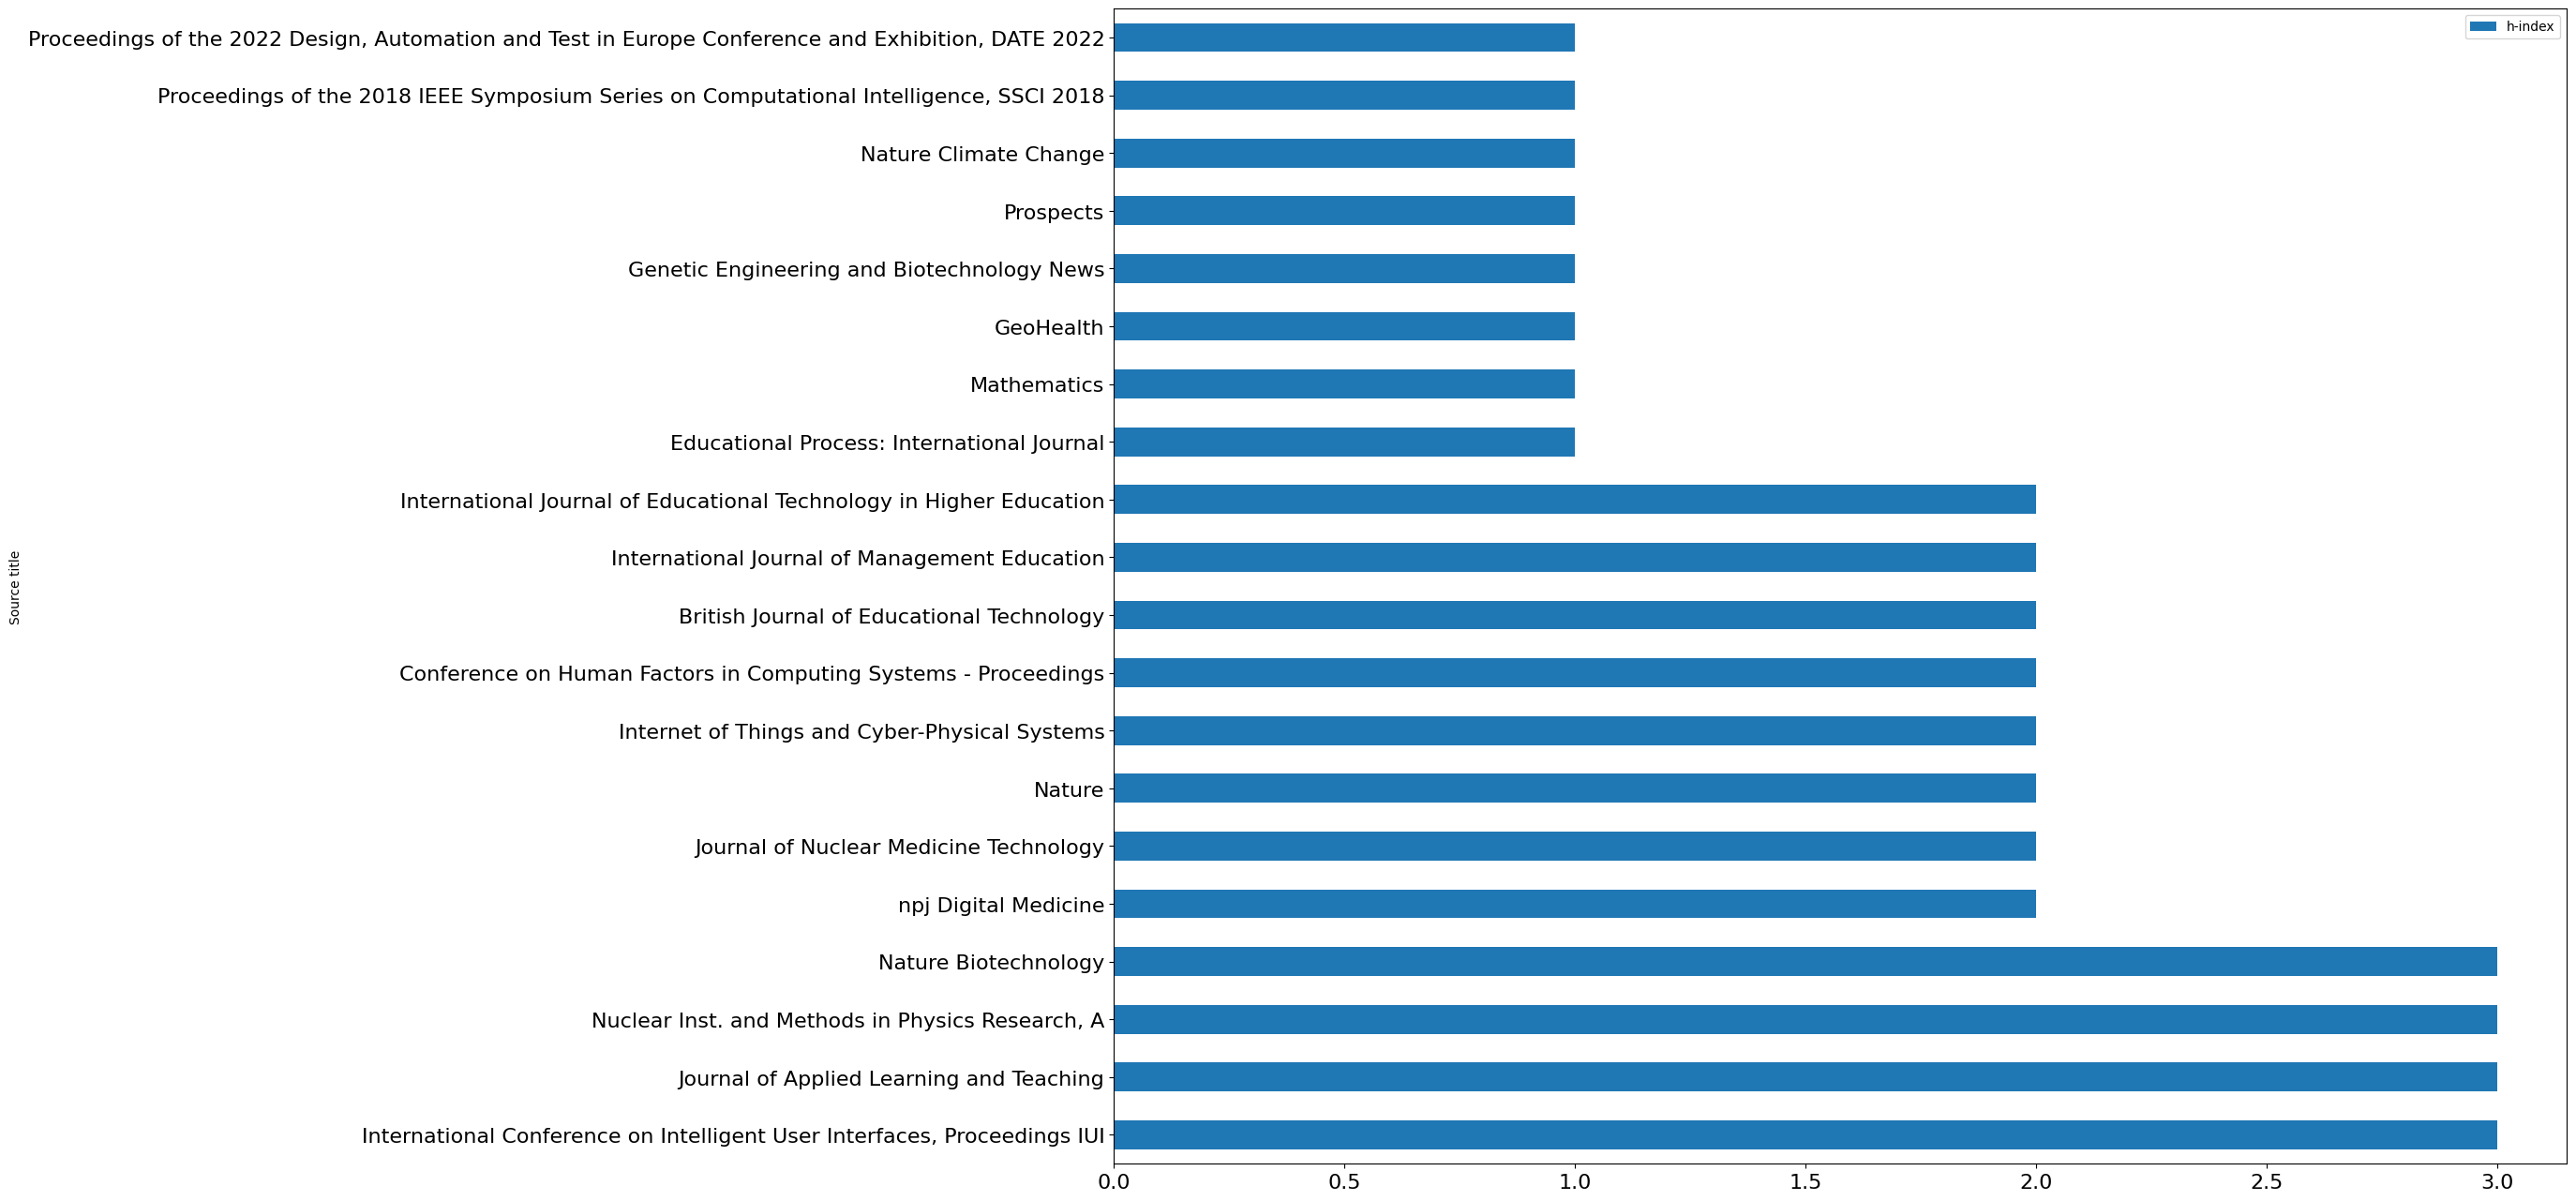

In [13]:
scopus_journals['h-index'] = scopus_journals.groupby('Source title')['Cited by'].transform( lambda x: (x >= x.count()).sum() )

scopus_journals = scopus_journals.groupby(['Source title']).max().reset_index()

scopus_journals.to_csv("sources.csv", index=False)

scopus_journals_sorted = scopus_journals.sort_values(by=['h-index'], ascending=False).head(20).reset_index()

fig = scopus_journals_sorted.plot(figsize=(20, 16), fontsize=16, kind='barh', x="Source title", y="h-index").get_figure()

fig.savefig('top20SourcesByHindex.pdf', bbox_inches='tight')

There are many other analyses and visualisations we can create here, but this gives us a good starting point. Feel free to play around here and find analyses that suit your particular project. However, the tutorial will now move on to the (neural) topic model of our data.

##Fitting the Topic Model
Before we can fit the topic model we need to make sure all the data contains the text we need to feed into our model. If we inspect our CSV we will likely notice that some list "[No abstract available]". We will need to remove these before continuing but you may want to review these papers manually if they are relevant to your research question.

In [ ]:
# drop any records that have a missing abstract
scopus = scopus.drop(scopus[scopus.Abstract == "[No abstract available]"].index)
scopus.head(10)

One benefit of the BERTopic approach to topic modelling is that (via the hierachical nature of HDBSCAN) we do not need to specify the number of expected topics upfront - the algorithm will find an appropriate number.

However, this will be influenced by some of the hyperparameters (user controlled parameters of the algorithms) and the size of the dataset. What can often happen is that in a small dataset (which in this context is something below ~1,000 records) the algorithm will create very few topics (due to lack of examples); whereas a very large dataset (something above ~3,000 records) can often create 100+ topics which can then be time consuming to interpret.

To counter this, we will dynamically change two hyperparameters based on the size of the dataset (corpus). In effect we will force the algorithm to find more examples in the documents before determining a new topic in a larger dataset, and fewer examples will be needed for a smaller dataset. If you have time and/or if you are unhappy with the number of topics being generated, you can experiment with different values here to see what gives the best results.

_It is worth noting here that, given this is a machine learning/deep learning approach, we do need enough data to "learn" the patterns. While there is no one number that can be given for a minimum dataset size (it will be dependent on how variable/diverse the data is among other things), you probably need a few hundred examples at a minimum and should prefer 500+. Remember that we are letting the algorithm trim our data and find the relevant papers so there is less need to be particularly restrictive on your search terms compared to a manual literature review process._

In [15]:
def hyperP_scaler(corpus):
  '''
  function to dynamically set hyperparameters for BERTopic based on dataset size
  input: a dataset of text (a corpus)
  output: min_topi_size and n_neighbors (for UMAP) hyperparameter choices
  '''
  topic_size = int(len(corpus) / 2000 * 10) + 1
  umap_size = int(len(corpus) / 2000 * 15) + 1
  return topic_size, umap_size

n_topics, n_umap = hyperP_scaler(scopus)
print(f"t={n_topics}, u={n_umap}") # print the hyperparameter values to screen

t=3, u=4


We will now build the topic model (which may take some time) using these parameters.

In [16]:
docs = scopus['Abstract'] # use the abstracts as the text data (corpus)

from umap import UMAP
# update UMAP with our dynamically derrived value. Can be replaced with your own prefered (integer) value
umap_model = UMAP(n_neighbors=n_umap)

# use KeyBERTInspired as our embedding model
representation_model = bertopic.representation.KeyBERTInspired()

# define the topic model and hyperparameters - change min_topic_size if desired to an integer value
topic_model = bertopic.BERTopic(min_topic_size=n_topics, representation_model=representation_model, umap_model=umap_model)

# fit the model to the data
topics, probabilities = topic_model.fit_transform(docs)

##Analysis of the Topics
Now we have fit our model we can analyse our results and try to interpret the subject matters our topics discuss.

In [17]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,96,-1_ai_creativity_technology_generative,"[ai, creativity, technology, generative, tools...",[The rapid advancements in generative AI model...
1,0,21,0_generative_autoencoder_cyclegan_imaging,"[generative, autoencoder, cyclegan, imaging, i...",[New advancements for the detection of synthet...
2,1,15,1_ai_creativity_generative_collaboration,"[ai, creativity, generative, collaboration, in...",[There has recently been much discussion aroun...
3,2,15,2_ai_educational_chatbots_education,"[ai, educational, chatbots, education, academi...","[With the release of ChatGPT in November 2022,..."
4,3,15,3_marketing_ai_hospitality_service,"[marketing, ai, hospitality, service, advertis...",[Purpose: The purpose of this study is to anal...
5,4,12,4_programming_tutoring_learners_generative,"[programming, tutoring, learners, generative, ...",[The introduction of OpenAI Codex sparked a su...
6,5,11,5_innovation_ai_industry_technology,"[innovation, ai, industry, technology, organiz...",[The widespread adoption of advanced technolog...
7,6,11,6_ai_regulation_regulatory_aia,"[ai, regulation, regulatory, aia, law, liabili...",[This article analyses the EU's regulation of ...
8,7,11,7_ai_medical_healthcare_health,"[ai, medical, healthcare, health, medicine, ph...",[Objective: Physical inactivity is a leading m...
9,8,11,8_chatbots_ai_tutoring_educational,"[chatbots, ai, tutoring, educational, learners...",[Learning technologies often do not meet the u...


The above table shows a series of fields:


1.   Topic number - an ID for each topic. Note that "-1" is not a topic but outliers not matching any topic.
2.   Count - the number of documents where this is the main topic.
3. Name - an autogenerated name for the topic formed by combing the three most "descriptive" words in the topic.
4. Representation - a list of words that are most "descriptive" of the topic.
5. Representative_Docs - example documents that are most associated with the topic.

In some cases it will be relatively obvious what a topic is about. For instance, for me at least, topic 48 which has as its _Representation_ "software, generative, engineering, engineers,..." and _Representative\_Docs_	"The software development industry is amid ano..", would be about genAI in software engineering. In other cases it will be less obvious. However, we have other tools at our disposal to investigate further.


In [18]:
fig = topic_model.visualize_topics()

fig.write_html("distanceMap.html")
fig

One such option is the __Intertopic Distance Map__. This shows, as the name suggest, the topics that are closely related and/or overlap. Each circle represents a topic, its size is representative of its prevalence in the data, and each is plotted across two dimensions representing semantic meaning. You can use the slider to select different topics and the image is saved as a HTML web page for local analysis or to download as an image.

In this case I may be interested in the use of genAI in research, and may notice a grouping of topics in the bottom left quarter of the graph towards the centre that seem to address this (topics 22, 31, 44 and 48).

Another option is to try to inspect more word associated with each topic:

In [19]:
# print words associated with each topic
topic_labels = topic_model.generate_topic_labels(nr_words=10, # increase to 10 words per topic
                                                 topic_prefix=True,
                                                 word_length=10,
                                                 separator=", ")
topic_labels


['-1, ai, creativity, technology, generative, tools, intelligen, technologi, developmen, text, creative',
 '0, generative, autoencode, cyclegan, imaging, images, neural, deep, imagery, wgan, visual',
 '1, ai, creativity, generative, collaborat, interactiv, creative, workshop, collaborat, interact, collaborat',
 '2, ai, educationa, chatbots, education, academic, assessment, educators, assessment, students, literacy',
 '3, marketing, ai, hospitalit, service, advertisin, customer, consumer, intelligen, generative, industry',
 '4, programmin, tutoring, learners, generative, ai, computing, students, software, learning, exams',
 '5, innovation, ai, industry, technology, organizati, capabiliti, technologi, emerging, organizati, business',
 '6, ai, regulation, regulatory, aia, law, liability, eu, risks, governance, risk',
 '7, ai, medical, healthcare, health, medicine, physicians, doctors, interventi, clinical, patient',
 '8, chatbots, ai, tutoring, educationa, learners, education, students, s

This has given us a bit more insight into our topics. For instance, topic #28, which looked relevant in the intertopic map, give us "scholarly, editors, journals, ai, manuscript, manuscript, publicatio, authorship, publishing, researchor" - all of which look relevant to my (pretend) area.

This is a very long list though. We could also just print a subset of the topic (ones we previously identified as potentially interesting). We will use our list from earlier.

In [20]:
# topic to print
# you can add any relevant topic numbers here between the square brackets - each separated by a comma
labels_to_print = [22, 31, 44, 48] # print topics 22, 31, 44 and 48
for i in range(len(topic_labels)):
  if i in labels_to_print:
    print(topic_labels[i+1])

22, scholarly, editors, ai, journals, manuscript, manuscript, publicatio, journal, publishing, authors
31, chatbots, ai, texts, plagiarism, scholar, documents, essays, knowledge, papers, text
44, law, ai, litigation, jurisdicti, opensource, legal, compliance, text, foia, contract
48, chatbot, ai, chat, datachat, dialogflow, tools, language, macro, deductive, intelligen


While getting extended keywords can help us understand a bit more about our topics, its not most "visual" of methods. We may find the use of word clouds a bit more expressive:

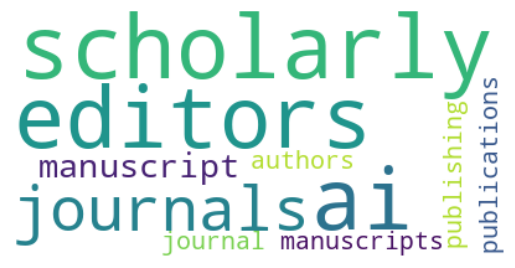

In [23]:
def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    return plt

# Show wordcloud
cloud = create_wordcloud(topic_model, topic=22) # create a wordcloud of topic 22
cloud.savefig('cloud_topic22.png', bbox_inches='tight')
cloud.show()

We can also inspect the _Representative\_Docs_ (the abstracts most associated with each topic). Let's look at some for topic # 22:

In [24]:
topic_model.representative_docs_[22] # replace 22 with whatever topic number you want to inspect

['The ethics of generative artificial intelligence (AI) use in scientific manuscript content creation has become a serious matter of concern in the scientific publishing community. Generative AI has computationally become capable of elaborating research questions; refining programming code; generating text in scientific language; and generating images, graphics, or figures. However, this technology should be used with caution. In this editorial, we outline the current state of editorial policies on generative AI or chatbot use in authorship, peer review, and editorial processing of scientific and scholarly manuscripts. Additionally, we provide JMIR Publications’ editorial policies on these issues. We further detail JMIR Publications’ approach to the applications of AI in the editorial process for manuscripts in review in a JMIR Publications journal. ©Tiffany I Leung, Taiane de Azevedo Cardoso, Amaryllis Mavragani, Gunther Eysenbach.',
 'Generative artificial intelligence (AI) has the p

We can also make (and save and print) a bar chart showing how relevant each word is with each topic:

In [25]:
# visualise all topics. We count the length of the topic labels - i.e. the number of topics
# subtract 1 to remove the outliers
fig = topic_model.visualize_barchart(top_n_topics=len(topic_model.topic_labels_)-1)

fig.write_html("Topics.html")
fig

While this may be useful for an appendix, it will take up a lot of real-estate if in the main text. Instead we may just want the topics of interest:

In [26]:
fig = topic_model.visualize_barchart(topics=[22, 31, 44, 48])

fig.write_html("topics_22_31_44_48.html")
fig

We can also look at the similarity between topics using a heatmap. The more blue (rather than green) each square is the stronger the correlation between the two topic. You'll see the diaganol axis is all blue (perfect correlation) because this is each topic correlated with itself.

Again, we will visualise all topics first of all and then look at a subset:

In [27]:
topic_model.visualize_heatmap()


In [28]:
topic_model.visualize_heatmap(topics=[22, 31, 44, 48])

After looking more broadly at the topics, and finding our topics of interest, we now want to relate the topics to our actual abstracts. I.e. we want to use our topic analysis to help us find the most relevant papers.

Let's have a look at the associations:

In [29]:
topic_model.topics_[0:20]

[48, 53, 28, 16, 53, 36, -1, 56, -1, -1, 18, 2, 55, 36, 26, 14, 40, 5, -1, 25]

This shows us the first 20 abstracts. The first is mostly outlier, the second is mostly topic 50, the third topic 1 and so on. While this may be useful, it is also a significant simplification in this use case. No paper/abstract concerns just one topic, and we also lose any measure of how much each abstract discusses this topic.

Instead we want a _topic distribution_, to model each abstract as a mixture of topics with varying proportions. E.g. Consider the following abstract:

_"Generative artificial intelligence (AI) has the potential to transform many aspects of scholarly publishing. Authors, peer reviewers, and editors might use AI in a variety of ways, and those uses might augment their existing work or might instead be intended to replace it. We are editors of bioethics and humanities journals who have been contemplating the implications of this ongoing transformation. We believe that generative AI may pose a threat to the goals that animate our work but could also be valuable for achieving those goals..."_

We may conceive this as a mixture of topics such as "genAI for research", "genAI for scholarly publishing", possibly "ethics and genAI" and maybe others. A _topic distribution_ will give as a pseudo-percentage for each of our topics.

In [30]:
topic_distr, _ = topic_model.approximate_distribution(docs)
topic_distr.shape

(513, 58)

We have built our topic distribution and check the shape of the output to validate it. We see we have a table which has 513 rows (the number of records after removing the ones with missing abstracts) and 58 columns (the number of topics). A given cell of the table would give the proportion of the document associated with that row that focuses on the topic associted with that column.

We can concatenate (join) this with our existing dataset for further analysis:

In [31]:
# extract the labels for each topic
col_names = [*topic_model.topic_labels_.values()]

# build a dataframe of topic proportions (row as records, columns as topics)
topics_df = pd.DataFrame(topic_distr, columns=col_names[1:])
topics_df.head()

,0_generative_autoencoder_cyclegan_imaging,1_ai_creativity_generative_collaboration,2_ai_educational_chatbots_education,3_marketing_ai_hospitality_service,4_programming_tutoring_learners_generative,5_innovation_ai_industry_technology,6_ai_regulation_regulatory_aia,7_ai_medical_healthcare_health,8_chatbots_ai_tutoring_educational,9_semantic_knowledge_retrieval_generative,...,48_chatbot_ai_chat_datachat,49_generative_programming_software_explainability,50_ai_productivity_organizational_workforce,51_simulators_realtime_streaming_virtual,52_ai_creative_generative_aitraining,53_spectrometer_gammaray_gamma_neutron,54_gans_generative_learners_educational,55_generative_ai_creative_inspiration,56_chatgpt_gpt_chatbot_patientsdata,57_improvisation_dancelikeness_generative_procedural
0,0.015467,0.007972,0.032216,0.009357,0.010330,0.010733,0.011106,0.019967,0.012821,0.025851,...,0.202580,0.000000,0.000000,0.0,0.000000,0.000000,0.008629,0.034035,0.033262,0.019165
1,0.016759,0.000000,0.000000,0.000000,0.016854,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.950633,0.000000,0.000000,0.000000,0.000000
2,0.035752,0.005589,0.000000,0.004074,0.017575,0.003841,0.000000,0.000000,0.000000,0.004946,...,0.008009,0.034502,0.000000,0.0,0.012803,0.000000,0.016725,0.000000,0.000000,0.000000
3,0.023771,0.023678,0.009931,0.005118,0.010415,0.022365,0.015873,0.015009,0.013822,0.018855,...,0.003798,0.039623,0.008591,0.0,0.009500,0.000000,0.008188,0.003961,0.008307,0.004248
4,0.009679,0.007869,0.010630,0.010216,0.009052,0.010746,0.008900,0.009529,0.008993,0.009954,...,0.006976,0.018918,0.007714,0.0,0.000000,0.575051,0.000000,0.000000,0.000000,0.006661


In [ ]:
# concatentate the topic proportions with the original dataframe
output = pd.concat([scopus, topics_df], axis=1) # axis 1 means adding as columns (to the right)
output.head()

We can finally output this dataframe as a CSV to conduct further analyses. For instance, it can be useful to set rules around the column proportions and other data to create an inclusion criteria for your literature review.

In [33]:
output.to_csv("output.csv", index=False)

And that's it! Hope you enjoyed the brief tutorial and happy to help further in this space. 👍